# import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input

In [2]:
# seed hold

random_seed = 42
SEED = 42
np.random.seed(random_seed)
import os
import random

import tensorflow as tf

random.seed(random_seed)


def set_seeds(seed=SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)


def set_global_determinism(seed=SEED, fast_n_close=False):

    set_seeds(seed=seed)
    if fast_n_close:
        return
        logging.warning(
            "*******************************************************************************"
        )
        logging.warning(
            "*** set_global_determinism is called,setting full determinism, will be slow ***"
        )
        logging.warning(
            "*******************************************************************************"
        )
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
        os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
        # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)
        from tfdeterminism import patch

        patch()


set_seeds()
set_global_determinism()

# Make dataset for train

In [3]:
# read_csv

path = "../dataset/data/Media/"
data1 = pd.read_csv(path + "Media_INFO.csv")
data2 = pd.read_csv(path + "Media_LOGIN.csv")
data3 = pd.read_csv(path + "Media_MENU.csv")
data4 = pd.read_csv(path + "Media_STREAM.csv")

In [4]:
# make all

all_data = pd.merge(data1, data2, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data3, on="Timestamp", how="inner")
all_data = pd.merge(all_data, data4, on="Timestamp", how="inner")

In [5]:
all_data.drop(["Timestamp"], inplace=True, axis=1)

In [6]:
# fillna mean

all_data = all_data.fillna(all_data.mean())

In [7]:
# copy data

train = all_data.copy()
train.shape

(210240, 33)

## Transform to sequence

In [8]:
step = 5

def trans_sequences(df, step):
    temp = []
    for i in range(len(df)-step+1):
        temp.append(df.iloc[i:(i+step)].values)
    
    return np.array(temp)

train_seq = trans_sequences(train, step)

print(f'Training shape: {train_seq.shape}')

Training shape: (210236, 5, 33)


## feature scaling

In [9]:
train_seq_for_scale = train_seq.copy()
train_number = train_seq_for_scale.shape[0]
feature_number = train_seq_for_scale.shape[2]

In [10]:
scaler = MinMaxScaler()

for i in range(step):
    scaler.partial_fit(train_seq_for_scale[:, i, :])

In [11]:
scaled_array = []

for i in range(step):
    scaled_array.append(scaler.transform(train_seq_for_scale[:, i, :]).reshape(train_number, 1, feature_number))
    
train_scaled = np.concatenate(scaled_array, axis=1)

# modeling

In [12]:
train_ntimepredict = train_scaled[:, 1:, :]
outstep = train_ntimepredict.shape[1]
epochs = 10
batch_size = 256
validation_split = 0.2
earlystop_patience = 2

Metal device set to: WARNING:tensorflow:Layer lstm will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-12 15:56:35.547091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-12 15:56:35.547427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 33)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 5, 16)        3200        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 5, 16)        0           ['lstm[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 8)            800         ['dropout[0][0]']                
                                                                                              

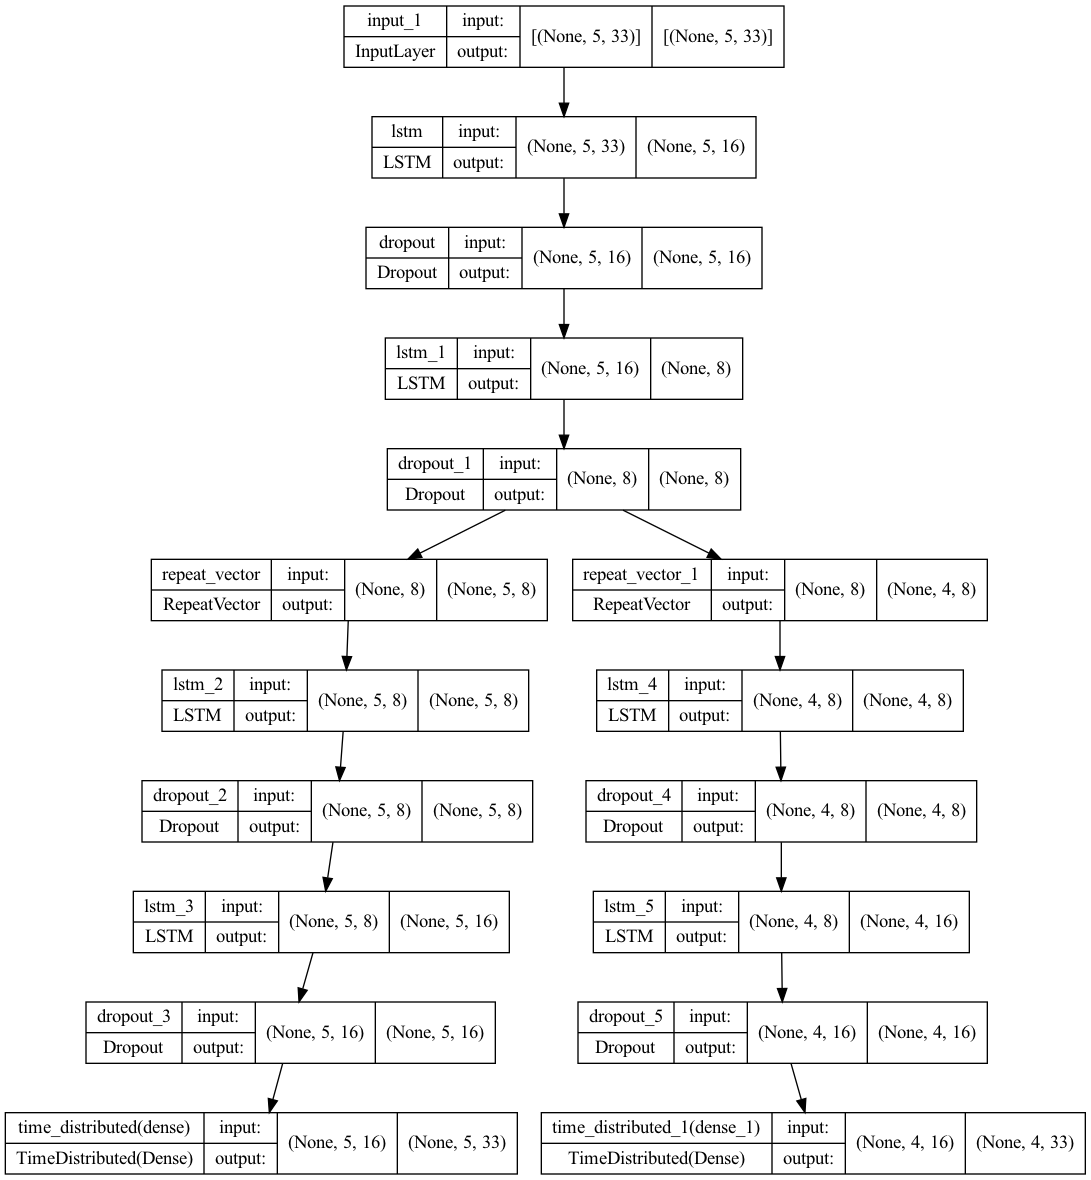

In [13]:
# encoder
pre_input = Input(shape=(step,feature_number))
encoder = LSTM(16, activation='relu', return_sequences=True)(pre_input)
encoder = Dropout(.1)(encoder)
encoder = LSTM(8, activation='relu', return_sequences=False)(encoder)
encoder = Dropout(.1)(encoder)

# reconstruct decoder
decoder1 = RepeatVector(step)(encoder)
decoder1 = LSTM(8, activation='relu', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = LSTM(16, activation='relu', return_sequences=True)(decoder1)
decoder1 = Dropout(.1)(decoder1)
decoder1 = TimeDistributed(Dense(feature_number))(decoder1)

# predict decoder
decoder2 = RepeatVector(outstep)(encoder)
decoder2 = LSTM(8, activation='relu', return_sequences=True)(decoder2)
decoder2 = Dropout(.1)(decoder2)
decoder2 = LSTM(16, activation='relu', return_sequences=True)(decoder2)
decoder2 = Dropout(.1)(decoder2)
decoder2 = TimeDistributed(Dense(feature_number))(decoder2)

# tie
lstm_autoencoder = Model(inputs=pre_input, outputs=[decoder1, decoder2])
lstm_autoencoder.summary()
lstm_autoencoder.compile(optimizer='adam', loss='mse')
plot_model(lstm_autoencoder, show_shapes=True)

In [14]:
# fit

history = lstm_autoencoder.fit(train_scaled, [train_scaled, train_ntimepredict], epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=earlystop_patience, mode='min')], shuffle=False)

Epoch 1/10


2022-05-12 15:56:36.496936: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-12 15:56:37.971679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


657/657 [==============================] - ETA: 0s - loss: 0.0033 - time_distributed_loss: 0.0016 - time_distributed_1_loss: 0.0017

2022-05-12 15:59:10.071937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


657/657 [==============================] - 159s 238ms/step - loss: 0.0033 - time_distributed_loss: 0.0016 - time_distributed_1_loss: 0.0017 - val_loss: 0.0011 - val_time_distributed_loss: 5.6583e-04 - val_time_distributed_1_loss: 5.4575e-04
Epoch 2/10
657/657 [==============================] - 171s 260ms/step - loss: 0.0015 - time_distributed_loss: 7.9370e-04 - time_distributed_1_loss: 7.4648e-04 - val_loss: 0.0011 - val_time_distributed_loss: 5.7948e-04 - val_time_distributed_1_loss: 5.6848e-04
Epoch 3/10
657/657 [==============================] - 204s 310ms/step - loss: 0.0013 - time_distributed_loss: 7.0109e-04 - time_distributed_1_loss: 6.4649e-04 - val_loss: 0.0011 - val_time_distributed_loss: 5.2697e-04 - val_time_distributed_1_loss: 6.0719e-04


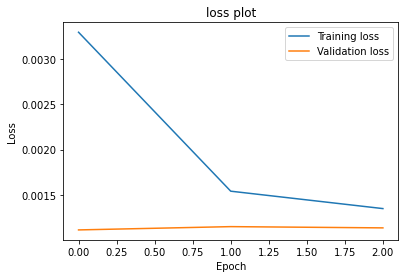

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.title('loss plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Make dataset for test

In [16]:
test = all_data[105120:]
test.reset_index(drop=True, inplace=True)

## Transform to sequence

In [17]:
test_seq = trans_sequences(test, step)

print(f'Training shape: {test_seq.shape}')

Training shape: (105116, 5, 33)


## feature scaling

In [18]:
test_seq_for_scale = test_seq.copy()
test_number = test_seq_for_scale.shape[0]

In [19]:
scaled_array = []

for i in range(step):
    scaled_array.append(scaler.transform(test_seq_for_scale[:, i, :]).reshape(test_number, 1, feature_number))
    
test_scaled = np.concatenate(scaled_array, axis=1)

# Predict & anormaly detect

In [20]:
test_predictions = lstm_autoencoder.predict(test_scaled)

2022-05-12 16:05:59.869711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [21]:
print(test_predictions[0].shape)
print(test_predictions[1].shape)

(105116, 5, 33)
(105116, 4, 33)


In [23]:
reconstruction_mse = np.mean(np.mean(np.power(test_scaled - test_predictions[0], 2), axis=1), axis=1)
prediction_mse = np.mean(np.mean(np.power(test_scaled[:, 1:, :] - test_predictions[1], 2), axis=1), axis=1)

In [47]:
reconstruction_mse + prediction_mse

array([0.02510704, 0.01442692, 0.01298717, ..., 0.04410841, 0.0540161 ,
       0.06887291])

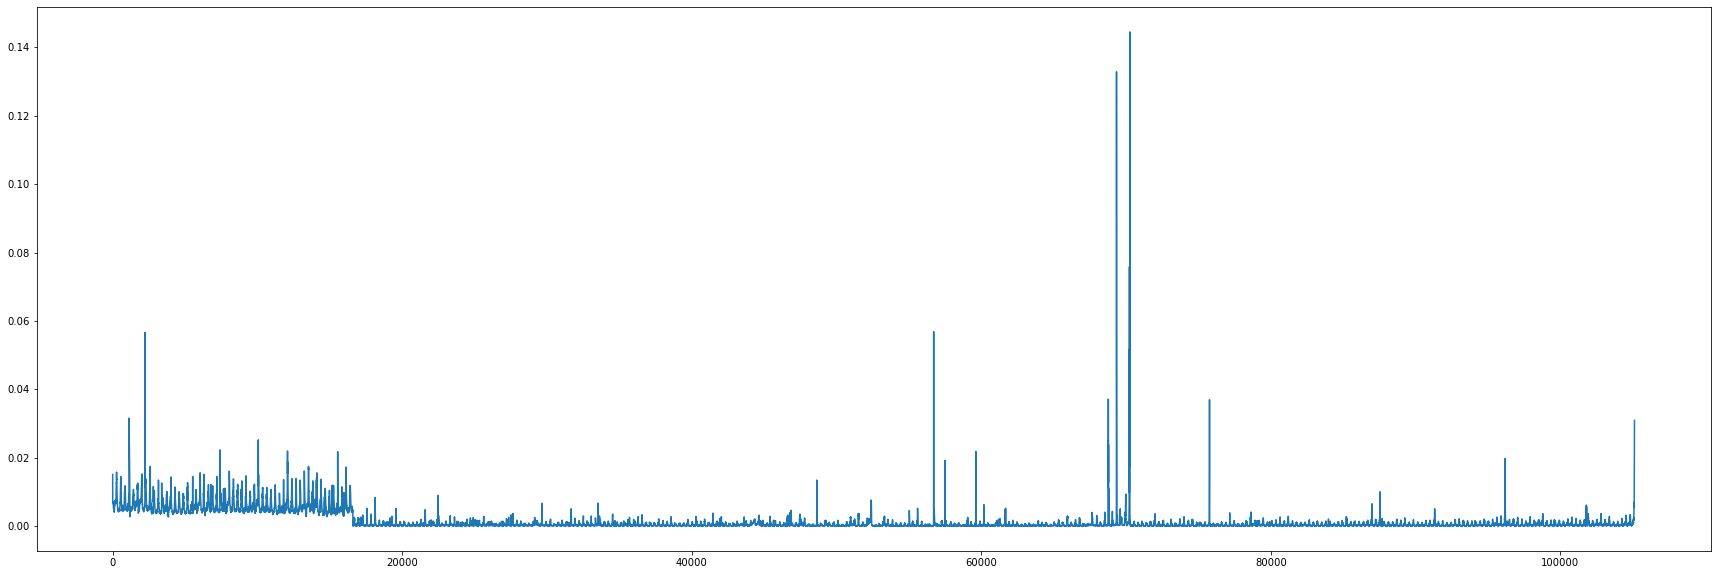

In [25]:
plt.figure(figsize = (30,10))
plt.plot(pd.DataFrame(reconstruction_mse).index, reconstruction_mse)

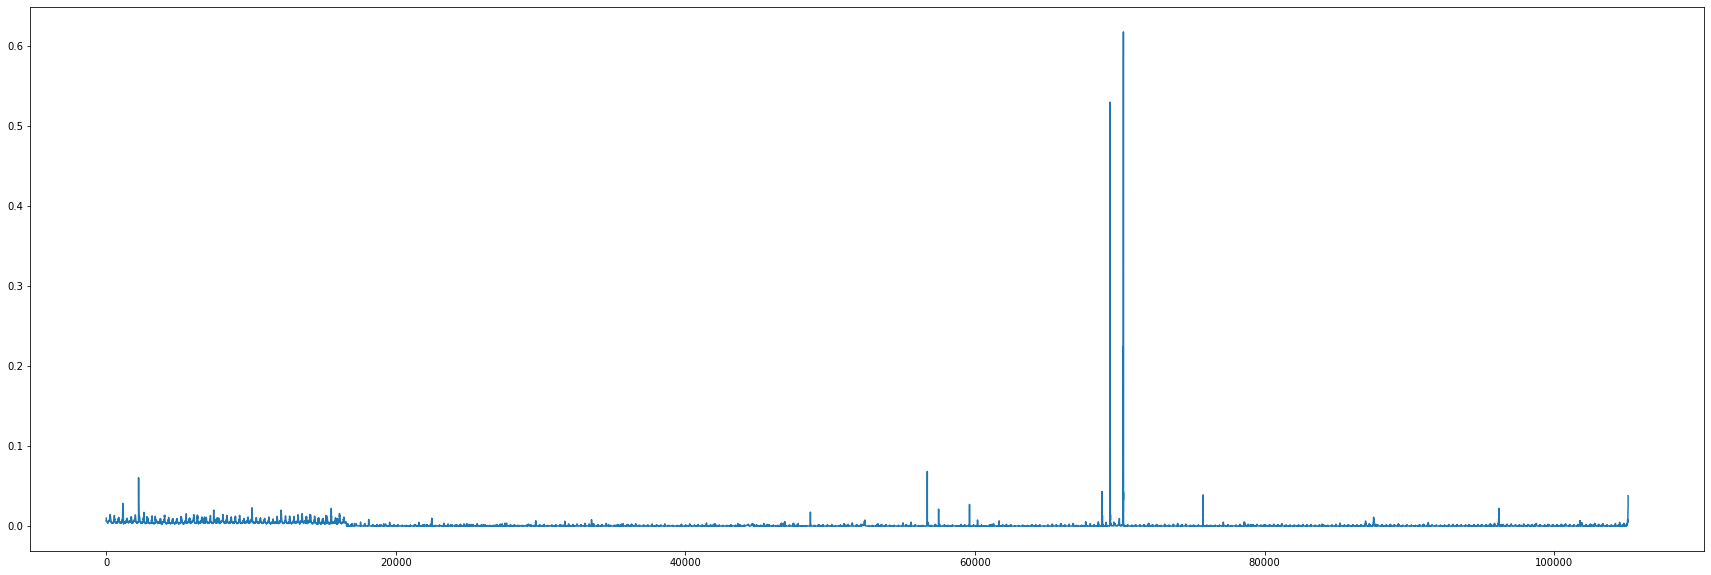

In [26]:
plt.figure(figsize = (30,10))
plt.plot(pd.DataFrame(prediction_mse).index, prediction_mse)

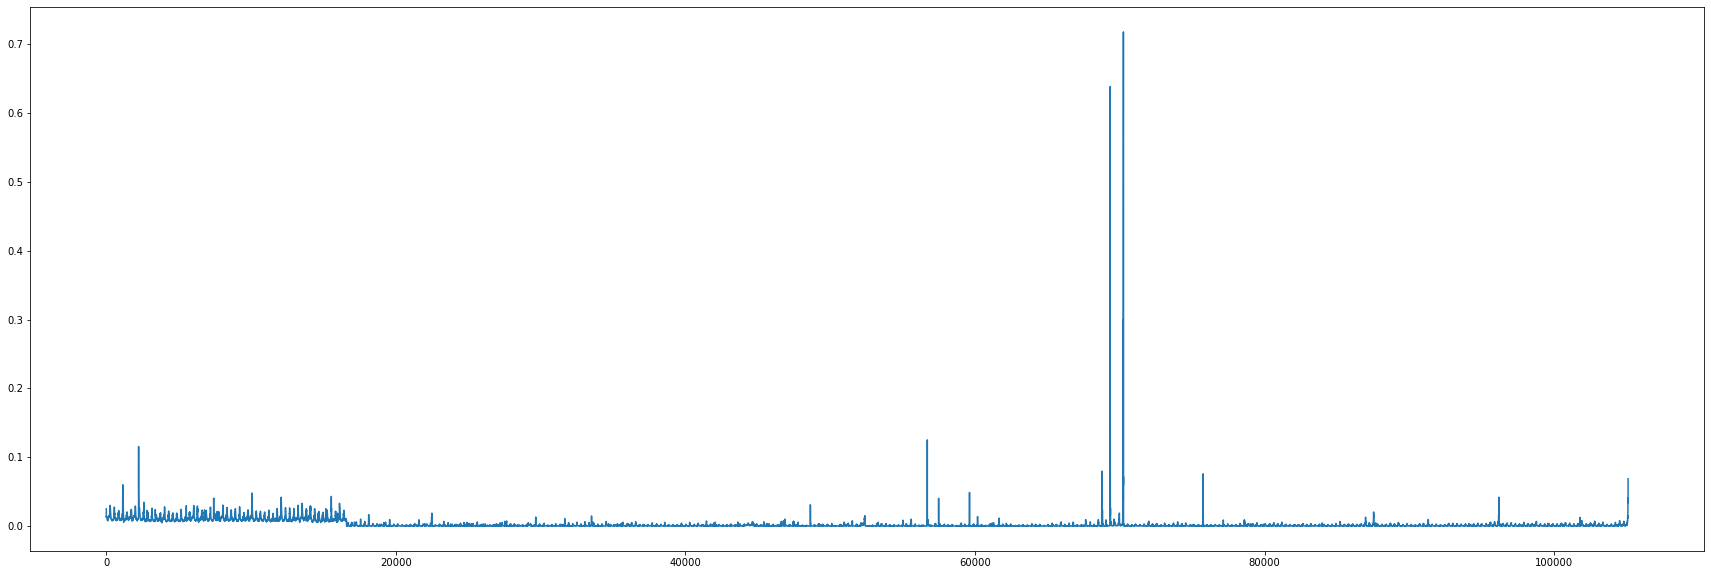

In [41]:
plt.figure(figsize = (30,10))
plt.plot(pd.DataFrame(prediction_mse).index, (prediction_mse + reconstruction_mse))

In [46]:
abs(reconstruction_mse + prediction_mse).mean()

0.002660343004959032

In [44]:
error = list((reconstruction_mse + prediction_mse) > 0.03)
for _ in range(4):
    error.insert(0, error[0])
error = pd.DataFrame(error, columns=['Prediction'])
error['Prediction'].replace(True, 1, inplace=True)
error['Prediction'].replace(False, 0, inplace=True)
print(error.value_counts(), len(error))

Prediction
0             104836
1                284
dtype: int64 105120


In [45]:
error.to_csv('error minmax.csv', mode='w')